In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn

     |████████████████████████████████| 1.5MB 5.9MB/s 
     |████████████████████████████████| 9.5MB 18.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 5.0MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=068c60c2588da188187e827c7f2fdc36bfec848e0a1a8a0d8e5273a1b3a14b21
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 93kB/s 
     |████████████████████████████████| 901kB 38.6MB/s 
     |████████████████████████████████| 10.1MB 46.9MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 5.2MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # numpy arrays / linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px # map plot
import warnings
warnings.filterwarnings('ignore') 

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as md
%matplotlib inline
from scipy.optimize import curve_fit # predictive modeling
import seaborn as sns
import statsmodels.api as sm

import datetime
from datetime import date

In [4]:
df=pd.read_csv('/content/drive/MyDrive/dataset/country_vaccinations.csv')
data2=pd.read_csv('/content/drive/MyDrive/dataset/covid-19-main/data/countries-aggregated.csv')

In [5]:
df.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,35.0,Oxford/AstraZeneca,Government of Afghanistan,https://reliefweb.int/report/afghanistan/afgha...


In [6]:
#fill out missing values for the latest update
df['total_vaccinations'] = df.groupby('country')['total_vaccinations'].ffill()
df['people_vaccinated'] = df.groupby('country')['people_vaccinated'].ffill()
df['people_fully_vaccinated'] = df.groupby('country')['people_fully_vaccinated'].ffill()
df['people_vaccinated'] = df.groupby('country')['people_vaccinated'].ffill()
df['total_vaccinations_per_hundred'] = df.groupby('country')['total_vaccinations_per_hundred'].ffill()
df['people_vaccinated_per_hundred'] = df.groupby('country')['people_vaccinated_per_hundred'].ffill()
df['people_fully_vaccinated_per_hundred'] = df.groupby('country')['people_fully_vaccinated_per_hundred'].ffill()
df = df.fillna(0) #all remaining NA change to 0
df.tail(10)

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
15656,Zimbabwe,ZWE,2021-04-27,433939.0,370676.0,63263.0,22329.0,15562.0,2.92,2.49,0.43,1047.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15657,Zimbabwe,ZWE,2021-04-28,458013.0,388021.0,69992.0,24074.0,17860.0,3.08,2.61,0.47,1202.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15658,Zimbabwe,ZWE,2021-04-29,477597.0,400771.0,76826.0,19584.0,17971.0,3.21,2.70,0.52,1209.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15659,Zimbabwe,ZWE,2021-04-30,500342.0,414735.0,85607.0,22745.0,19194.0,3.37,2.79,0.58,1291.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15660,Zimbabwe,ZWE,2021-05-01,520299.0,428135.0,92164.0,19957.0,21171.0,3.50,2.88,0.62,1424.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15661,Zimbabwe,ZWE,2021-05-02,524199.0,430068.0,94131.0,3900.0,19169.0,3.53,2.89,0.63,1290.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15662,Zimbabwe,ZWE,2021-05-03,537516.0,437751.0,99765.0,13317.0,17987.0,3.62,2.95,0.67,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15663,Zimbabwe,ZWE,2021-05-04,559777.0,452191.0,107586.0,22261.0,17977.0,3.77,3.04,0.72,1210.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15664,Zimbabwe,ZWE,2021-05-05,576233.0,461023.0,115210.0,16456.0,16889.0,3.88,3.10,0.78,1136.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...
15665,Zimbabwe,ZWE,2021-05-06,607355.0,478174.0,129181.0,31122.0,18537.0,4.09,3.22,0.87,1247.0,Sinopharm/Beijing,Ministry of Health,https://twitter.com/MoHCCZim/status/1390390738...


In [7]:
#country list
country = df['country'].unique()
total_vacc = []
people_vaccinated = []
people_fully_vaccinated = []
total_vacc_per_hundred = []
people_vacc_per_hundred = []
people_fully_vacc_per_hundred = []
vacc_type = []
dates = []

for i in range(0,len(country)):
        #getting the numpy array with the latest total_vaccinations number
        total_vacc.append(df["total_vaccinations"][df['country'] == country[i]].iloc[-1])
        #getting the numpy array with the latest people_vaccinated number
        people_vaccinated.append(df["people_vaccinated"][df['country'] == country[i]].iloc[-1])
        #getting the numpy array with the latest people_fully_vaccinated number
        people_fully_vaccinated.append(df["people_fully_vaccinated"][df['country'] == country[i]].iloc[-1])
        #data per hundred
        total_vacc_per_hundred.append(df["total_vaccinations_per_hundred"][df['country'] == country[i]].iloc[-1])
        people_vacc_per_hundred.append(df["people_vaccinated_per_hundred"][df['country'] == country[i]].iloc[-1])
        people_fully_vacc_per_hundred.append(df["people_fully_vaccinated_per_hundred"][df['country'] == country[i]].iloc[-1])  
        #vaccines type
        vacc_type.append(df["vaccines"][df['country'] == country[i]].iloc[-1])  
        #getting the numpy array with the latest date update
        dates.append(df["date"][df['country'] == country[i]].iloc[-1])  
        
df_actual = pd.DataFrame({'total_vaccinations': total_vacc, 
                            'people_vaccinated': people_vaccinated, 
                            'people_fully_vaccinated': people_fully_vaccinated,
                            'total_vacc_per_hundred': total_vacc_per_hundred,
                            'people_vacc_per_hundred': people_vacc_per_hundred,
                            'people_fully_vacc_per_hundred': people_fully_vacc_per_hundred,
                            'vacc_type': vacc_type,
                            'update_date': dates}, 
                             index = country)
df_actual['total_vaccinations'] = df_actual['total_vaccinations'].astype(int)
df_actual['people_vaccinated'] = df_actual['people_vaccinated'].astype(int)
df_actual['people_fully_vaccinated'] = df_actual['people_fully_vaccinated'].astype(int)
df_actual.head(10)

,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_vacc_per_hundred,people_vacc_per_hundred,people_fully_vacc_per_hundred,vacc_type,update_date
Afghanistan,240000,240000,0,0.62,0.62,0.00,Oxford/AstraZeneca,2021-04-22
Albania,572226,6073,655,19.88,0.21,0.02,"Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...",2021-05-06
Algeria,75000,0,0,0.17,0.00,0.00,Sputnik V,2021-02-19
Andorra,28881,24182,4699,37.38,31.30,6.08,"Oxford/AstraZeneca, Pfizer/BioNTech",2021-05-03
Angola,456349,456349,0,1.39,1.39,0.00,Oxford/AstraZeneca,2021-04-23
Anguilla,6898,6115,783,45.98,40.76,5.22,Oxford/AstraZeneca,2021-04-22
Antigua and Barbuda,29754,29754,0,30.38,30.38,0.00,Oxford/AstraZeneca,2021-04-22
Argentina,8591061,7399515,1191546,19.01,16.37,2.64,"Oxford/AstraZeneca, Sinopharm/Beijing, Sputnik V",2021-05-06
Armenia,565,565,0,0.02,0.02,0.00,Sputnik V,2021-03-31
Aruba,79553,55371,24182,74.51,51.86,22.65,Pfizer/BioNTech,2021-05-06


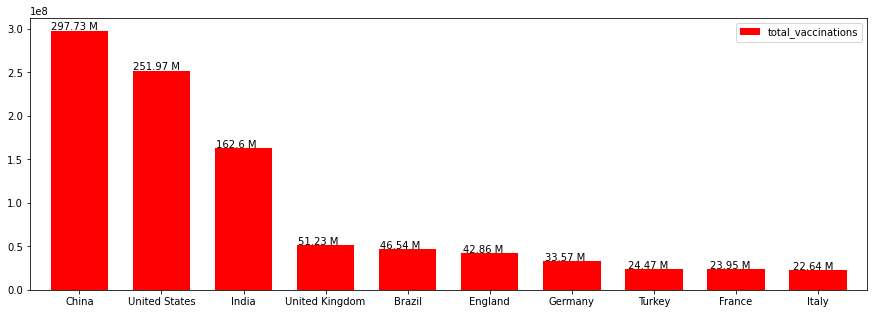

In [8]:
df_top1 = df_actual.nlargest(10, 'total_vaccinations')
plt.rcParams["figure.figsize"] = (15,5)
ax = df_top1.plot.bar(y='total_vaccinations', color='red', rot=0,  width = 0.7)
for p in ax.patches:
        ax.annotate(str(round(p.get_height()/1000000, 2)) + " M", (p.get_x() * 1.005, p.get_height() * 1.005))

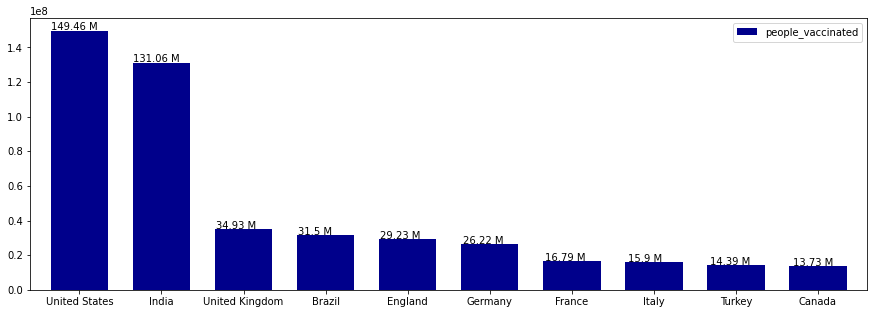

In [9]:
df_top2 = df_actual.nlargest(10, 'people_vaccinated')
plt.rcParams["figure.figsize"] = (15,5)
ax = df_top2.plot.bar(y='people_vaccinated', color='darkblue', rot=0,  width = 0.7)
for p in ax.patches:
        ax.annotate(str(round(p.get_height()/1000000, 2)) + " M", (p.get_x() * 1.005, p.get_height() * 1.005)) 

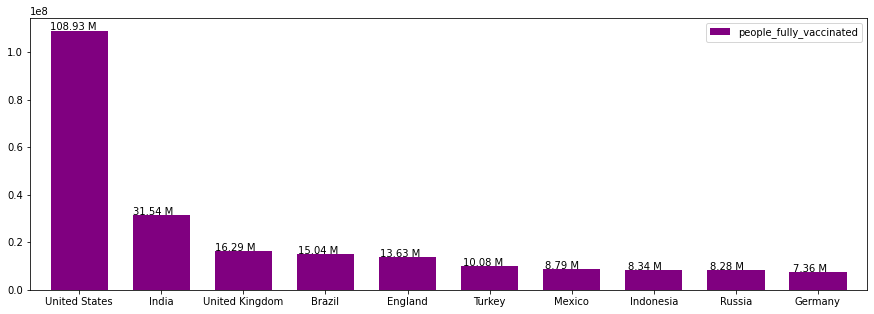

In [10]:
df_top3 = df_actual.nlargest(10, 'people_fully_vaccinated')
plt.rcParams["figure.figsize"] = (15,5)
ax = df_top3.plot.bar(y='people_fully_vaccinated', color='purple', rot=0,  width = 0.7)
for p in ax.patches:
        ax.annotate(str(round(p.get_height()/1000000, 2)) + " M", (p.get_x() * 1.005, p.get_height() * 1.005)) 

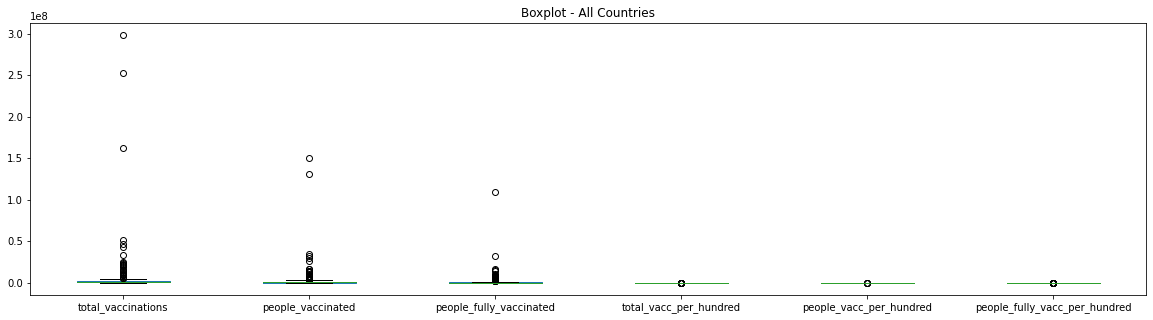

In [11]:
mpl.rcParams['figure.figsize'] = (20,5)
df_actual.plot(kind = 'box', title = 'Boxplot - All Countries')

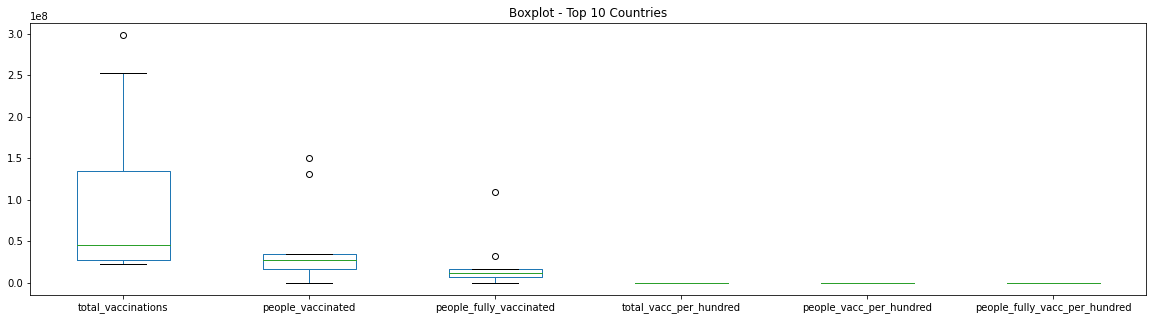

In [12]:
df_top1 = df_actual.nlargest(10, 'total_vaccinations')
mpl.rcParams['figure.figsize'] = (20,5)
df_top1.plot(kind = 'box', title = 'Boxplot - Top 10 Countries')

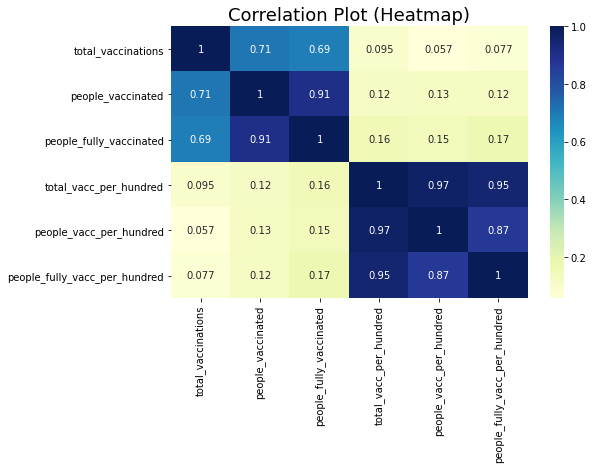

In [13]:
correlation_matrix = df_actual.corr()
plt.subplots(figsize=(8,5))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title('Correlation Plot (Heatmap)', size=18)
plt.show()

Text(0.5, 1.0, 'Bar plot - % of population fully vaccinated')

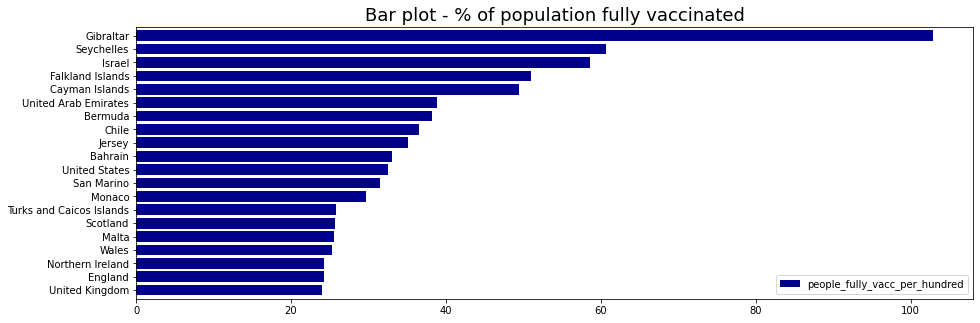

In [14]:
df_top4 = df_actual.nlargest(20, 'people_fully_vacc_per_hundred')
df_top4.sort_values(by=['people_fully_vacc_per_hundred'], inplace=True)
plt.rcParams["figure.figsize"] = (15,5)
ax = df_top4.plot.barh(y='people_fully_vacc_per_hundred', color='darkblue', rot=0, width = 0.8)
plt.title("Bar plot - % of population fully vaccinated", size=18)

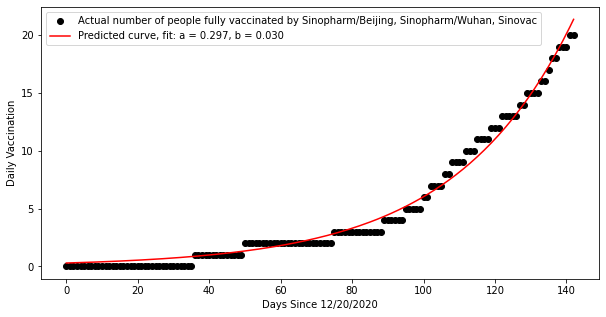

In [15]:
#Levenberg–Marquardt (LM) Algorithm
def func(x, a, b):
    return a * np.exp(b * x)

#select the US data'
df_ina = df[df['vaccines'] == 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']
df_ina['total_vaccinations_per_hundred'] = df_ina['total_vaccinations_per_hundred'].astype(int)
y =df_ina['total_vaccinations_per_hundred'].to_numpy() #depended variable
x = np.arange(len(y)) #independent variable

#Data and Predictive Modelling in Pandemics https://www.youtube.com/watch?v=zk2ptM4H2Uk&feature=youtu.be
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ko', label='Actual number of people fully vaccinated by Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac')
popt, pcov = curve_fit(func, x, y, p0=(1, 0.1))
plt.plot(x, func(x, *popt), 'r-', label='Predicted curve, fit: a = %5.3f, b = %5.3f' % tuple(popt))
plt.xlabel('Days Since 12/20/2020')
plt.ylabel('Daily Vaccination')
plt.legend()
plt.show()

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_t1= y
y_t1[y_t1 == 0] = 1 # change 0 to1 tu exclude deviding by 0
y_t1 = y_t1[25:] # exclude first 40 days

y_p1 = func(x, *popt)
y_p1 = y_p1.astype(int)
y_p1[y_p1 < 0] = 1
y_p1 = y_p1[25:]

MAPE1 = mean_absolute_percentage_error(y_t1, y_p1)
print ("MAPE (Mean Absolute Percentage Error) = " + str(round(MAPE1,2)) + "%")

MAPE (Mean Absolute Percentage Error) = 23.82%


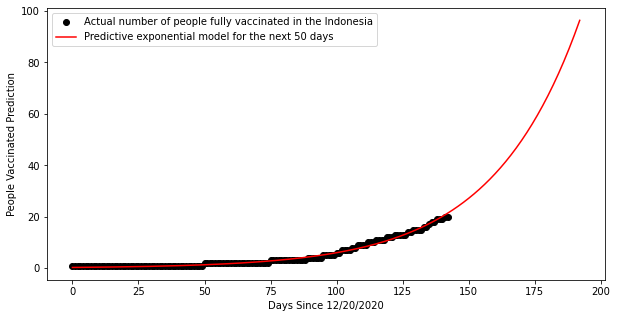

In [17]:
x2 = np.arange(len(y)+50)
y2_predicted = []
       
for i in range(0, len(x2)):
    y2_predicted.append(popt[0] * np.exp((popt[1]) * x2[i]))
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ko', label='Actual number of people fully vaccinated in the Indonesia')    
plt.plot(x2, y2_predicted, 'r-', label='Predictive exponential model for the next 50 days')
plt.xlabel('Days Since 12/20/2020')
plt.ylabel('People Vaccinated Prediction')
plt.legend()
plt.show()

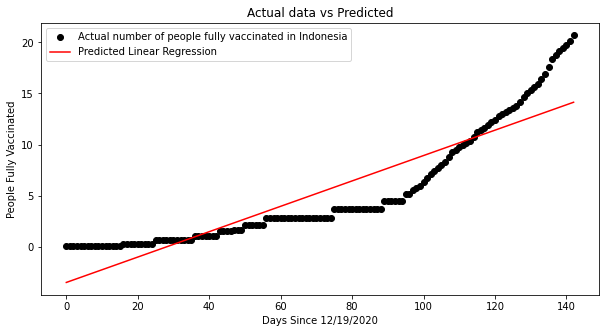

In [18]:
'select Indonesia data'
df_indonesia = df[df['vaccines'] == 'Sinopharm/Beijing, Sinopharm/Wuhan, Sinovac']
#df_indonesia['total_vaccinations'] = df_indonesia['total_vaccinations'].astype(int)
y = df_indonesia['total_vaccinations_per_hundred'].to_numpy() 
x = np.arange(len(y)) 

#Linear Regression https://towardsdatascience.com/introduction-to-linear-regression-in-python-c12a072bedf0
xmean = np.mean(x)
ymean = np.mean(y)
df_indonesia = df_indonesia.reset_index(drop=True)
df_indonesia.reset_index(level=0, inplace=True)
df_indonesia.head()

# Calculate the terms needed for the numator and denominator of beta
df_indonesia['xycov'] = (df_indonesia['index'] - xmean) * (df_indonesia['total_vaccinations_per_hundred'] - ymean)
df_indonesia['xvar'] = (df_indonesia['index'] - xmean)**2

# Calculate beta and alpha
beta = df_indonesia['xycov'].sum() / df_indonesia['xvar'].sum()
alpha = ymean - (beta * xmean)

ypred = alpha + beta * x

# Plot regression against actual data
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ko', label='Actual number of people fully vaccinated in Indonesia')     # scatter plot showing actual data
plt.plot(x, ypred, 'r-', label='Predicted Linear Regression')   # regression line
plt.title('Actual data vs Predicted')
plt.xlabel('Days Since 12/19/2020')
plt.ylabel('People Fully Vaccinated')
plt.legend()
plt.show()


In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_t2= y
y_t2[y_t2 == 0] = 1 # change 0 to1 tu exclude deviding by 0
y_t2 = y_t2[40:] # exclude first 40 days

y_p2 = ypred
y_p2 = y_p2.astype(int)
y_p2[y_p2 < 0] = 1
y_p2 = y_p2[40:]

MAPE = mean_absolute_percentage_error(y_t2, y_p2)
print ("MAPE (Mean Absolute Percentage Error) = " + str(round(MAPE,2)) + "%")

MAPE (Mean Absolute Percentage Error) = 33.54%


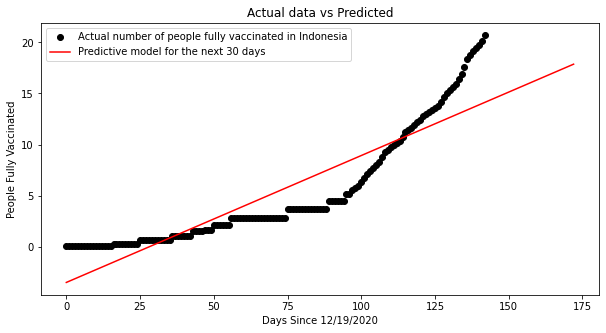

In [20]:
x1 = np.arange(len(y)+30)
y1_predicted = []
       
for i in range(0, len(x1)):
    y1_predicted.append(popt[0] * np.exp((popt[1]) * x1[i]))
    
ypred1 = alpha + beta * x1
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ko', label='Actual number of people fully vaccinated in Indonesia')     # scatter plot showing actual data
plt.plot(x1, ypred1, 'r-', label='Predictive model for the next 30 days')   # regression line
plt.title('Actual data vs Predicted')
plt.xlabel('Days Since 12/19/2020')
plt.ylabel('People Fully Vaccinated')
plt.legend()
plt.show()

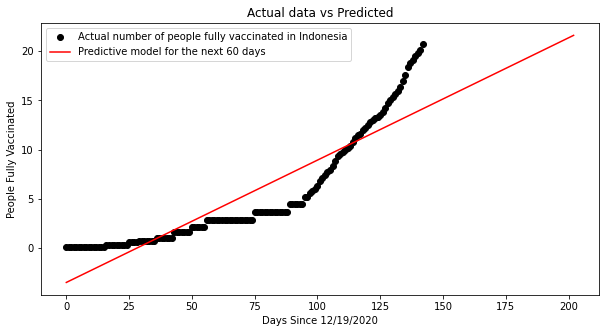

In [21]:
x2 = np.arange(len(y)+60)
y2_predicted = []
       
for i in range(0, len(x1)):
    y2_predicted.append(popt[0] * np.exp((popt[1]) * x2[i]))
    
ypred2 = alpha + beta * x2
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ko', label='Actual number of people fully vaccinated in Indonesia')     # scatter plot showing actual data
plt.plot(x2, ypred2, 'r-', label='Predictive model for the next 60 days')   # regression line
plt.title('Actual data vs Predicted')
plt.xlabel('Days Since 12/19/2020')
plt.ylabel('People Fully Vaccinated')
plt.legend()
plt.show()

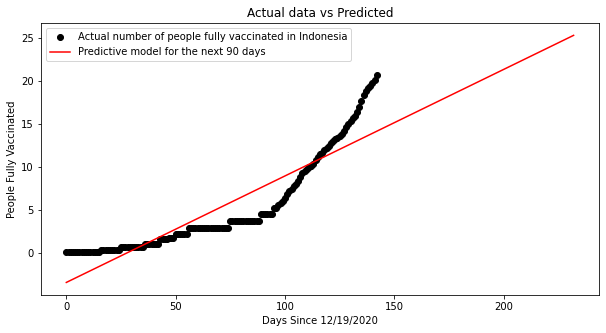

In [22]:
x2 = np.arange(len(y)+90)
y2_predicted = []
       
for i in range(0, len(x1)):
    y2_predicted.append(popt[0] * np.exp((popt[1]) * x2[i]))
    
ypred2 = alpha + beta * x2
plt.figure(figsize=(10, 5))
plt.plot(x, y, 'ko', label='Actual number of people fully vaccinated in Indonesia')     # scatter plot showing actual data
plt.plot(x2, ypred2, 'r-', label='Predictive model for the next 90 days')   # regression line
plt.title('Actual data vs Predicted')
plt.xlabel('Days Since 12/19/2020')
plt.ylabel('People Fully Vaccinated')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Vaccine Combinations')

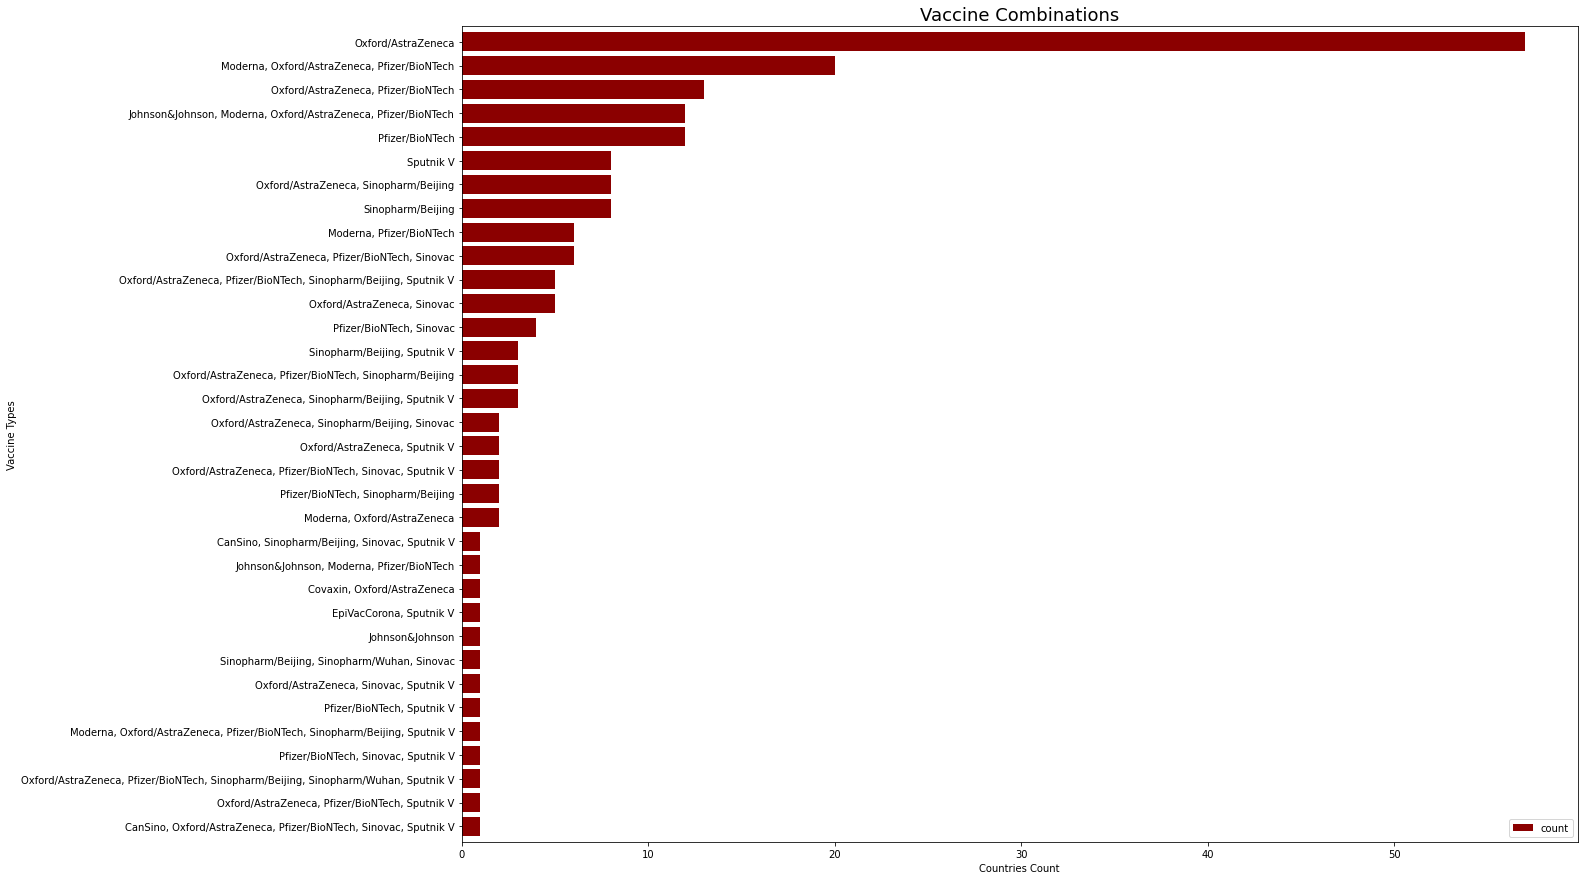

In [23]:
vacc_type = df_actual.copy()
vacc_type.reset_index(level=0, inplace=True)
vacc_type = vacc_type.groupby('vacc_type').agg(['count'])
vacc_type_sorted = vacc_type.apply(lambda x: x.sort_values(ascending=True))

plt.rcParams["figure.figsize"] = (20,15)
ax = vacc_type_sorted.plot.barh(y='index', color='darkred', rot=0, width = 0.8)
plt.xlabel('Countries Count')
plt.ylabel('Vaccine Types')
plt.title('Vaccine Combinations', size=18)

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_t1, y_p1)

0.7542372881355932

In [25]:
from sklearn.metrics import r2_score
r2_score(y_t1, y_p1)

0.9758728349993223

In [26]:
y_p1.mean()

5.423728813559322

In [27]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_t1, y_p1))

0.6186440677966102


In [28]:
from sklearn.metrics import median_absolute_error
print(median_absolute_error(y_t1, y_p1))

1.0


In [29]:
from math import sqrt
rmse = sqrt(mean_squared_error(y_t1, y_p1))
print(rmse)

0.8684683575903


In [30]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_t1, y_p1)

0.23819962127277028